# Outline

* Why Derivative Free Optimization? 
* Initialize black box that we want to minimize
* Uniform Random Search
* Random Search
* Coordinate Descent
* Particle Swarm

# Why Derivative Free Optimization? 

* Dosage Optimization in Clinical Trials
* Chemical Process Optimization
* Hyperparameter Tuning
* Parameter Estimation in Simulation (i.e. find simulation parameters that best match observed real world data)

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-12-08 11:50:21.690536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initializing Our Black Box

In [3]:
# Set random seets
tf.random.set_seed(42)
np.random.seed(42)

# Build Random Dataset N=100, D=4
N = 10
X = np.random.randn(N, 4)
y = np.random.randn(N, 5)

# Min-Max Scaling of X so that D = [0, 1]^4
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Build a model with 4 inputs, 1 output, and 2 hidden layers with 10 neurons each
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model with MSE loss and SGD optimizer
model.compile(loss='mse', optimizer='SGD')

# Train the model for 100 epochs
model.fit(X, y, epochs=100)

# Save model
model.save('model.h5')

Epoch 1/100
1/1 [==============================] - 1s 764ms/step - loss: 0.9001
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.8965
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.8934
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.8906
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 0.8879
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.8855
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 0.8832
Epoch 8/100
1/1 [==============================] - 0s 22ms/step - loss: 0.8812
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 0.8792
Epoch 10/100
1/1 [==============================] - 0s 11ms/step - loss: 0.8774
Epoch 11/100
1/1 [==============================] - 0s 24ms/step - loss: 0.8757
Epoch 12/100
1/1 [==============================] - 0s 22ms/step - loss: 0.8742
Epoch 13/100
1/1 [==============================

/Users/evans/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
# Import model
black_box_model = tf.keras.models.load_model('model.h5')


# Uniform Random Search

Algorithm: 
* Uniformly sample our domain
* Test value, update "best so far"
* Stop after some halting condition

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

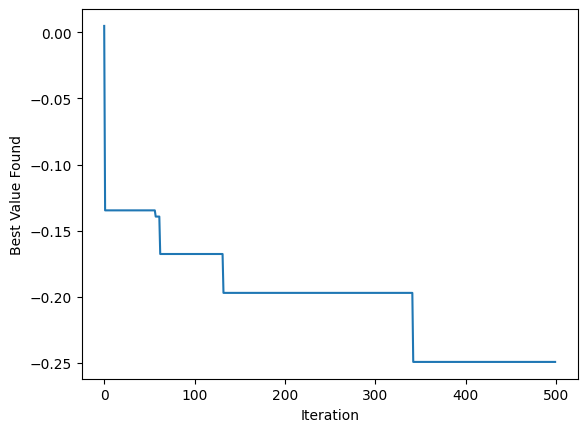

In [3]:
# Uniform Random Search
num_iter = 500
best_val = float('inf')
best_params = None
historic_val = []
for i in range(num_iter):
    print(i)
    # Generate uniform random parameters between 0 and 1
    params = np.random.rand(4)
    val = black_box_model.predict(params.reshape(1, -1), verbose=False)[0]
    if val < best_val:
        best_val = val
        best_params = params
    historic_val.append(best_val)

# Print best loss and best parameters
print(f'Best loss: {best_val}')
print(f'Best parameters: {best_params}')

# Plot the loss over time
plt.plot(historic_val)
plt.xlabel('Iteration')
plt.ylabel('Best Value Found')
plt.show()



# Random Search (With Radius)

Algorithm: 
Given a stopping condition S and radius $r$
* Uniformly initialize starting point $x_0$
* Randomly sample unit sphere to get $y$
* Update $x_{n+1}$ to be the better of $x_n$ and $x_n + r y$
* Halt upon S.

Marsaglia's Algorithm for randomly sampling the unit sphere of dimension $d$: 
* For $1 \leq i \leq d$, take i.i.d. $x_i \sim N(0, 1)$
* $\vec{x} = (x_1, \dots, x_d)$
* Return $\frac{\vec{x}}{||\vec{x}||}$ which will be uniformly distributed on the unit sphere. 

Best loss: [-0.20136923]
Best parameters: [0.97981191 0.99941649 0.0191307  0.40850295]


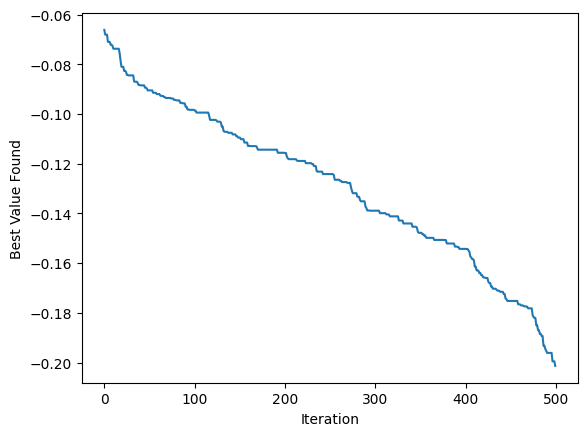

In [4]:
# Marsaglia's Algorithm
def sample_unit_ball(d):
    x = np.random.randn(d)
    norm = np.linalg.norm(x)
    return x / norm

# Random Search (With Radius)  
num_iter = 500

# Initialize the parameters
params = np.random.rand(4)
best_params = params
best_val = black_box_model.predict(params.reshape(1, -1), verbose=False)[0]
historic_val = [best_val]
radius = 0.01

# Iterate
for i in range(num_iter-1):
    new_params = np.clip(params + sample_unit_ball(len(params)) * radius, 0, 1)
    val = black_box_model.predict(new_params.reshape(1, -1), verbose=False)[0]
    if val < best_val:
        best_val = val
        best_params = new_params
        params = new_params
    historic_val.append(best_val)

# Print best loss and best parameters
print(f'Best loss: {best_val}')
print(f'Best parameters: {best_params}')

# Plot the loss over time
plt.plot(historic_val)
plt.xlabel('Iteration')
plt.ylabel('Best Value Found')
plt.show()



In [5]:
# Marsaglia's Algorithm
def sample_unit_ball(d):
    x = np.random.randn(d)
    norm = np.linalg.norm(x)
    return x / norm

# Random Search (With Radius)  
num_iter = 5000  # Increase the number of iterations to 5000

# Initialize the parameters
params = np.random.rand(4)
best_params = params
best_val = black_box_model.predict(params.reshape(1, -1), verbose=False)[0]
historic_val = [best_val]
radius = 0.01

# Iterate
for i in range(num_iter-1):
    new_params = np.clip(params + sample_unit_ball(len(params)) * radius, 0, 1)
    val = black_box_model.predict(new_params.reshape(1, -1), verbose=False)[0]
    if val < best_val:
        best_val = val
        best_params = new_params
        params = new_params
    historic_val.append(best_val)

# Print best loss and best parameters
print(f'Best loss: {best_val}')
print(f'Best parameters: {best_params}')

# Plot the loss over time
plt.plot(historic_val)
plt.xlabel('Iteration')
plt.ylabel('Best Value Found')
plt.show()


# Modified Random Search (Decaying Radius)

Similar to above, the only difference here is that we exponentially decay the radius by which we iterate. 

Best loss: [-0.06003921]
Best parameters: [0.51243031 0.9999598  0.         0.96698109]


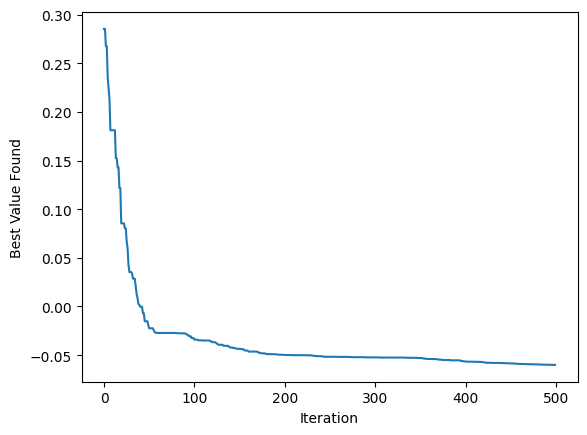

In [ ]:
# Marsaglia's Algorithm
def sample_unit_ball(d):
    x = np.random.randn(d)
    norm = np.linalg.norm(x)
    return x / norm

# Random Search (With Radius)  
num_iter = 500

# Initialize the parameters
params = np.random.rand(4)
best_params = params
best_val = black_box_model.predict(params.reshape(1, -1), verbose=False)[0]
historic_val = [best_val]
radius = 0.1
radius_decay_rate = 0.99

# Iterate
for i in range(num_iter-1):
    radius *= radius_decay_rate
    new_params = np.clip(params + sample_unit_ball(len(params)) * radius, 0, 1)
    val = black_box_model.predict(new_params.reshape(1, -1), verbose=False)[0]
    if val < best_val:
        best_val = val
        best_params = new_params
        params = new_params
    historic_val.append(best_val)

# Print best loss and best parameters
print(f'Best loss: {best_val}')
print(f'Best parameters: {best_params}')

# Plot the loss over time
plt.plot(historic_val)
plt.xlabel('Iteration')
plt.ylabel('Best Value Found')
plt.show()



# Coordinate Descent

Enumerate the coordinate directions with some specified radius: 
$\{ (r, 0, \dots, 0), (0, r, 0 \dots), \dots, (0, \dots, 0, -r)\}$

Initialize $x$ uniformly randomly and initialize a direction $r_k$

Iterate:
* Conduct a line search from $x$ in the direction of $r_k$
    * If $f(x + r_k) < f(x)$, then update $x := x+ r_k$, 
    * Else, break
* Update direction $r_{k+1 \mod 2d}$ and repeat
* Halt upon stopping condition

In [ ]:
# Coordinate Descent
num_iter = 500

# Initialize the parameters
params = np.random.rand(4)
best_params = params
best_val = black_box_model.predict(params.reshape(1, -1), verbose=False)[0]
historic_val = [best_val]
radius = 0.1

# Create list of coordinate directions for dimension 4 with radius = radius
coordinate_directions = np.concatenate((np.eye(4) * radius, np.eye(4) * radius * -1), axis=0)

# Begin Search 
iterations_completed = 0
directions_searched = 0
while(iterations_completed < num_iter):
    # Get direction to search
    direction = coordinate_directions[directions_searched % len(coordinate_directions)]
    directions_searched += 1
    
    # Search this direction until you don't get a better loss
    while True:
        new_params = np.clip(params + direction, 0, 1)
        # Break if we hit the edge of our domain
        if np.array_equal(params, new_params): 
            break
        
        val = black_box_model.predict(new_params.reshape(1, -1), verbose=False)[0]
        if val < best_val:
            best_val = val
            best_params = new_params
            params = new_params
        else:
            break
        historic_val.append(best_val)
        iterations_completed += 1
        if iterations_completed >= num_iter:
            break
    
    if iterations_completed >= num_iter:
        break
    
# Print best loss and best parameters
print(f'Best loss: {best_val}')
print(f'Best parameters: {best_params}')

# Plot the loss over time
plt.plot(historic_val)
plt.xlabel('Iteration')
plt.ylabel('Best Value So Far')
plt.show()

    
    


KeyboardInterrupt: 

# Problems So Far

Uniform Random Search is horribly inefficient

All others can be trapped in local minimums. 

# Particle Swarm

Instead of a single candidate solution, we have a "swarm" of candidate solutions that we call particles. 

Algorithm:

Parameters:
* Number of particles
* Halting Condition
* Inertia term $w \in (0, 1)$
    * This is effectively the momentum of the particle
* Cognitive Coefficient $\phi_p$
    * This is the individual particle's preference based on their best solution so far
* Social Coefficient $\phi_g$
    * This is the particle's preference based on the swarm's best solution so far

Initialization:
* Initialize $S$ particles uniformly on the domain $(x_1, \dots, x_S)$
* Initialize $p_i = x_i$ to be the particle's best position so far
* Initialize $g$ to be the best position throughout the swarm
* Initialize random velocities $v_i$

Until Stopping Condition is met:
* For each particle, perturb its velocity in the following way: 
    * For each dimension, choose $r_1, r_2 \sim U(0, 1)$. Update the particle's velocity in this dimension as follows: 
        $$v_{i, d} = w v_{i, d} + \phi_p r_1 (p_{i, d} - x_{i, d}) + \phi_g r_2 (g_d - x_{i, d})$$
        In words: It maintains it's current velocity by way of it's inertia $w$, it adds velocity in the direction of its best solution so far proportionally to $\phi_p r_1$, and it adds velocity in the direction of the swarm's best solution so far proportionally to $\phi_g r_2$. 
* Use this velocity to update the particle position $x_i := x_i + v_i$
* Test new position, update particle's best position so far $p_i$ and best swarm position so far $g$. 


Best loss: -0.20712852478027344
Best parameters: [1.         1.         0.63608245 0.21805812]


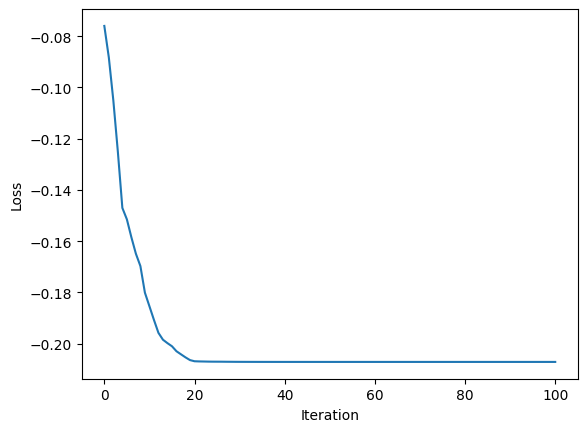

In [ ]:
# Set Algorithm Parameters
num_particles = 10
num_iter = 100
inertia = 0.5
cognitive = 0.5
social = 0.5

# Initialize the swarm
swarm = np.random.rand(num_particles, 4)
best_positions = swarm.copy()
best_losses = np.array([black_box_model.predict(x.reshape(1, -1), verbose=False)[0][0] for x in swarm])
best_swarm_loss = best_losses.min()
best_swarm_position = swarm[best_losses.argmin()].copy()

# Initialize velocities to N(0.1, 1)
velocities = np.random.randn(num_particles, 4) / 10

# Iterate
historic_loss = [best_swarm_loss]
for i in range(num_iter):
    # Update the swarm
    for j in range(num_particles):
        # Update velocity
        velocities[j] = inertia * velocities[j] + cognitive * np.random.rand() * (best_positions[j] - swarm[j]) + social * np.random.rand() * (best_swarm_position - swarm[j])
        
        # Update position
        swarm[j] += velocities[j]

        # Force swarm to be in [0,1]^4 
        swarm[j] = np.clip(swarm[j], 0, 1)
        
        # Update best position
        loss = black_box_model.predict(swarm[j].reshape(1, -1), verbose=False)[0][0]
        if loss < best_losses[j]:
            best_positions[j] = swarm[j].copy()
            best_losses[j] = loss
            if loss < best_swarm_loss:
                best_swarm_loss = loss
                best_swarm_position = swarm[j].copy()
    historic_loss.append(best_swarm_loss)


# Print best loss and best parameters
print(f'Best loss: {best_swarm_loss}')
print(f'Best parameters: {best_swarm_position}')

# Plot the loss over time
plt.plot(historic_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()



# Summary



# Simulated Annealing

# Nelder-Mead Method